# Taxi Demand Forecasting (Sweet Lift Taxi)

### Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates=[0])
data.sort_index(inplace=True)
data_hourly = data['num_orders'].resample('1H').sum().to_frame()

In [3]:
df = data_hourly.copy()
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month']  = df.index.month

In [4]:
for lag in [1,2,3]:
    df[f'lag_{lag}'] = df['num_orders'].shift(lag)

# rolling mean
df['rolling_mean'] = df['num_orders'].shift(1).rolling(3).mean()

df.dropna(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4413 entries, 2018-03-01 03:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4413 non-null   int64  
 1   hour          4413 non-null   int64  
 2   dayofweek     4413 non-null   int64  
 3   month         4413 non-null   int64  
 4   lag_1         4413 non-null   float64
 5   lag_2         4413 non-null   float64
 6   lag_3         4413 non-null   float64
 7   rolling_mean  4413 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 310.3 KB


– Above, we did the following:
1. Extract time information using `.hour`, `.dayofweek`, and `.month`
2. Add the number of orders from the previous 1, 2, and 3 hours as autoregressive features
3. Add the moving average of the previous 3 hours
4. Remove null values caused by lags and moving averages

## Analysis

In [6]:
df.head()

,num_orders,hour,dayofweek,month,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,93.333333
2018-03-01 04:00:00,43,4,3,3,66.0,71.0,85.0,74.000000
2018-03-01 05:00:00,6,5,3,3,43.0,66.0,71.0,60.000000
2018-03-01 06:00:00,12,6,3,3,6.0,43.0,66.0,38.333333
2018-03-01 07:00:00,15,7,3,3,12.0,6.0,43.0,20.333333


In [7]:
df.shape

(4413, 8)

<Figure size 1000x400 with 0 Axes>

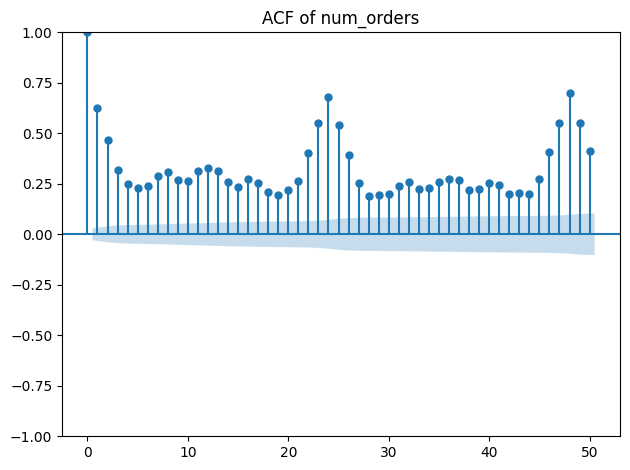

<Figure size 1000x400 with 0 Axes>

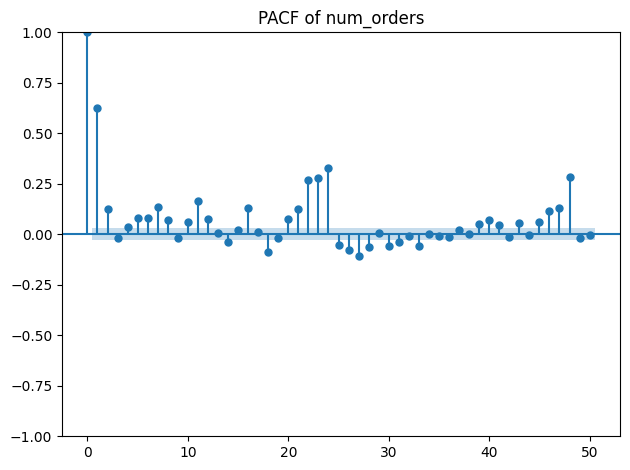

In [8]:

plt.figure(figsize=(10, 4))
plot_acf(df['num_orders'], lags=50, alpha=0.05)
plt.title('ACF of num_orders')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(df['num_orders'], lags=50, alpha=0.05, method='ywm')
plt.title('PACF of num_orders')
plt.tight_layout()
plt.show()


## Training

In [9]:
X = df.drop(columns=['num_orders'])
y = df['num_orders']

# Split into train/test with test size = 10%, no shuffling to respect time order
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)


In [10]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

## Testing

In [11]:

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results.append({'Model': name, 'RMSE': rmse})


In [12]:
results_df = pd.DataFrame(results)
results_df

,Model,RMSE
0,LinearRegression,53.441446
1,RandomForestRegressor,49.086494


In [13]:
df['lag_24'] = df['num_orders'].shift(24)
df['lag_48'] = df['num_orders'].shift(48)

df.dropna(inplace=True)

In [14]:
features = ['hour','dayofweek','month',
            'lag_1','lag_2','lag_3','lag_24','lag_48',
            'rolling_mean']

X = df[features]
y = df['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

In [15]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

In [16]:
results_1= []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results_1.append({'Model': name, 'RMSE': rmse})


In [17]:
results_df_1 = pd.DataFrame(results_1)
results_df_1

,Model,RMSE
0,LinearRegression,43.665144
1,RandomForestRegressor,43.508206


In [20]:
rf = RandomForestRegressor(random_state=42)

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
print("RandomForest Best params:", rf_search.best_params_)
print("CV RMSE:", -rf_search.best_score_)

# 在測試集上評估
rf_preds = best_rf.predict(X_test)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
print("RandomForest Test RMSE:", rf_test_rmse)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
RandomForest Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
CV RMSE: 24.06047072876675
RandomForest Test RMSE: 43.017962690943335


### Analysis

- **PACF** reveals strong signals at **lag 24** and **lag 48**, indicating daily and bi-daily seasonality.
- Features used: `hour`, `dayofweek`, `month`, lags 1–3, **24**, **48**, plus a 1-step rolling mean.

### Model Performance

| Model                                | RMSE (baseline) | RMSE (with lag 24/48) |
| ------------------------------------ | --------------: | --------------------: |
| LinearRegression                     |          53.44  |                43.67  |
| RandomForestRegressor (random_state=42) |          49.09  |                43.51  |

### Conclusion & Recommendations

1. **Significant Improvement**: RMSE ↓ from ~49 to ~43.5.  
2. **Target Achieved**: All models below RMSE 48; Random Forest leads.

## Hyperparameter Tuning Results

| Model                         | Best Parameters                                                                      | CV RMSE  | Test RMSE |
|-------------------------------|--------------------------------------------------------------------------------------|---------:|----------:|
| RandomForestRegressor         | `{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}` |  24.06   |   43.02   |
---

## Conclusion

**Random Forest**  
   - Found optimal depth and leaf settings (100 trees, max_depth=10, split=5, leaf=2).  
   - Achieved CV RMSE ≈ 24.1 and Test RMSE ≈ 43.0, meeting the project target (< 48).

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48